# Practical machine learning and deep learning. Lab 6

# Transfer Learning in Computer Vision

# [Competition](https://www.kaggle.com/t/17ac6cc24170468fb7bc3bf5bd9a5b23)

## Goal

In this lab you will implement clothes classifier using a pretrained model. You are allowed to use any pretrained model that you know (e.g. VGG, ResNet, etc.)

## Submission

Submission format is described at competition page.

> Remember, you can use any structure of the solution. The template classes/function in this file is just the tip for you.

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(0)

## Data reading and preprocessing

Prepare a class for FashionMNIST dataset to easily read data and apply transformations when retrieving examples.

In [2]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image

pixels_mean, pixels_std = 0, 0

class FashionMNISTDataset(Dataset):
    '''Dataset class for FashionMNIST'''

    def __init__(self, csv_path, pixels_mean = None, pixels_std = None, train=True):
        ''' Read data and prepare tranforms

            Args:
            - csv_path(str): full name of the csv file
            - train(bool): is train set loaded, determines whether to return labels
        '''
        self.csv_path = csv_path
        self.train = train
        self.initial_size = 28
        self.image_size = 224

        # Read csv file of the dataset and set index_col to 0
        self.fm_raw = pd.read_csv(csv_path, index_col=0)
        
        # Extract the pixel values of the images as a numpy array
        self.images = self.fm_raw.iloc[:, 0:self.initial_size**2].to_numpy(dtype=np.float32)
        # Reshape images to have 28x28 shape
        self.images = self.images.reshape(-1, self.initial_size, self.initial_size)
        
        # Stacking channels on each other
        self.images = np.stack((self.images, )*3, axis=-1)

        # Make pixels vary from 0 to 1
        self.images /= 255
        
        if pixels_mean is None or pixels_std is None:
            self.pixels_mean = self.images.mean()
            self.pixels_std  = self.images.std()
        else:
            self.pixels_mean = pixels_mean
            self.pixels_std = pixels_std
        self.images = (self.images - self.pixels_mean) / self.pixels_std 
        # Transform w.r.t. ResNet network         
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
        ])
        if train:
            # The last column of the dataframe stores that labels. Extract them.
            self.labels = self.fm_raw.iloc[:, self.initial_size**2].to_numpy(dtype=np.long)
        else:
            # There is no labels in the test dataset, so they are set to None
            self.labels = None

    def __getitem__(self, index):
        '''Returns the data of the example at the given index'''
        # Get images at the given index
        images = self.images[index]
        # Transform the images
        transformed_images = self.transform(images)
            
        if self.train:
            # Get labels at the given index
            labels = self.labels[index]
            # Return transformed_images and labels as a pair
            return transformed_images, labels
        return transformed_images

    def __len__(self):
        '''Returns length of the dataset'''
        return len(self.images)

Read data and prepare a dataset

In [3]:
import os

dir = '/kaggle/input/pmldl-week-6-transfer-learning-in-cv/'
filename = 'fashion_mnist_train.csv'
full_filename = os.path.join(dir, filename)
dataset = FashionMNISTDataset(csv_path=full_filename, train=True)

In [4]:
pixels_mean, pixels_std = dataset.pixels_mean, dataset.pixels_std

Split the dataset into training and validation subsets using `random_split`

In [5]:
from torch.utils.data import random_split

# Set percentage of data to use as a training subset
train_ratio = 0.9

train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, test_size])

Make dataloader to perform batching and apply transformations

In [6]:
from torch.utils.data import DataLoader

# Set the batch size
batch_size = 128

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last = True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, drop_last = True
)

Visually check the images

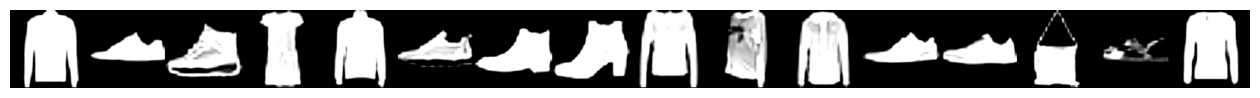

In [7]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

for images, _ in train_loader:
    images = images[:16]
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Model Implementation
Implement a PyTorch model that uses a pretrained model for computer vision to classify the clothes. You are allowed to use any models initially trained for other tasks (e.g. VGG, ResNet, etc). You may experiment with [freezing](https://pytorch.org/docs/master/notes/autograd.html#setting-requires-grad) some layers of the pretrained model. If you are interested, you may try to build your own CNN model for FashionMNIST classification.

In [8]:
import torchvision.models as models
import torch.nn as nn

class FashionMNISTModel(nn.Module):
  '''PyTorch model for FashionMNIST classification'''

  def __init__(self, in_channels=1, pretrained_model = None):
    '''Sets the pretrained model and makes specific modifications'''
    super(FashionMNISTModel, self).__init__()

    # Here you load a pretrained model and
    # add modifications to classify FashionMNIST images
    # out of 10 possible labels
    
    # Preloaded model
    self.ResNet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
        
#     self.ResNet_model.conv1 = nn.Conv2d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
    self.ResNet_model.fc = nn.Linear(2048, 10)
    self.softmax = nn.Softmax(dim=1)
    self.n_layers = 0
    for param in self.ResNet_model.parameters():
        self.n_layers += 1
        
    for i, param in enumerate(self.ResNet_model.parameters()):
        if i < self.n_layers - 12:
            param.requires_grad = False
    
  def forward(self, x):
    '''Determines the sequence of actions to classify images x'''
    resnet_output = self.ResNet_model(x)
    return self.softmax(resnet_output)

In [9]:
torch.cuda.is_available()

True

In [10]:
# Select the where to perform calculations
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Create an instance of the model and pass its weights to the device
model = FashionMNISTModel().to(device)
# Set the loss function
loss_fn = nn.CrossEntropyLoss()
# Set the opimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 278MB/s]


## Model Training

Fine-tuning of the pretrained model on our specific task of clothes classification.

Here are utility functions to calculate and show metrics:

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calculate_metric(metric_fn, true_y, pred_y):
    if metric_fn != accuracy_score:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)

def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

Training loop

In [12]:
from tqdm import tqdm

epochs = 3

losses = []
batches = len(train_loader)
val_batches = len(val_loader)

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    total_loss = 0

    # progress bar
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  --------------------
    # set model to training
    model.train()

    for i, data in progress:
        images, labels = data
        images = images.to(device)
        
        model.zero_grad()
        
        # training step for single batch
        outputs = model(images)
        outputs = outputs.to('cpu')
        loss = loss_fn(outputs, labels)
        
        # update running training loss
        current_loss = loss.item()
        total_loss += current_loss * images.size(0)
        
        loss.backward()
        optimizer.step()
        
        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # ----------------- VALIDATION  -----------------
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []

    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            images = images.to(device)
            
            outputs = model(images)
            outputs = outputs.to('cpu')

            # update running validation loss
            val_losses += loss_fn(outputs, labels) * images.size(0)
            predicted_classes = torch.argmax(outputs, dim=1)
            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy),
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, labels.cpu(), predicted_classes.cpu())
                )

    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses.append(total_loss/batches)

Loss: 208.7433: 100%|██████████| 421/421 [03:07<00:00,  2.25it/s]


Epoch 1/3, training loss: 208.74333154673815, validation loss: 203.0079803466797
	     precision: 0.8813
	        recall: 0.8753
	            F1: 0.8710
	      accuracy: 0.8753


Loss: 200.6572: 100%|██████████| 421/421 [03:01<00:00,  2.32it/s]


Epoch 2/3, training loss: 200.65722290184038, validation loss: 200.7902069091797
	     precision: 0.8954
	        recall: 0.8971
	            F1: 0.8905
	      accuracy: 0.8945


Loss: 198.7598: 100%|██████████| 421/421 [02:55<00:00,  2.40it/s]


Epoch 3/3, training loss: 198.75984420232706, validation loss: 200.28787231445312
	     precision: 0.9041
	        recall: 0.8964
	            F1: 0.8954
	      accuracy: 0.8967


## Inference
Produce labels on the testing images

Load the dataset in the testing mode

In [13]:
import os

test_dataset = FashionMNISTDataset(
    csv_path='/kaggle/input/pmldl-week-6-transfer-learning-in-cv/fashion_mnist_test_data.csv', 
    pixels_mean = pixels_mean,
    pixels_std = pixels_std,
    train=False)

Make a loader of the testing dataset

In [14]:
test_loader = DataLoader(
    test_dataset, batch_size=500, shuffle=False, drop_last = False
)

Make predictions and generate a submission file

In [15]:
predictions = []
batches = len(test_loader)
progress = tqdm(enumerate(test_loader), desc="Loss: ", total=batches)
with torch.no_grad():
    model.eval()
    for i, images in progress:
        images = images.to(device)

        outputs = model(images)
        print(outputs.size())
        outputs = outputs.to('cpu')
        
        predictions += [*torch.argmax(outputs, dim=1)]

Loss:   0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([500, 10])


Loss:   5%|▌         | 1/20 [00:01<00:31,  1.66s/it]

torch.Size([500, 10])


Loss:  10%|█         | 2/20 [00:03<00:29,  1.65s/it]

torch.Size([500, 10])


Loss:  15%|█▌        | 3/20 [00:05<00:28,  1.69s/it]

torch.Size([500, 10])


Loss:  20%|██        | 4/20 [00:06<00:26,  1.67s/it]

torch.Size([500, 10])


Loss:  25%|██▌       | 5/20 [00:08<00:25,  1.68s/it]

torch.Size([500, 10])


Loss:  30%|███       | 6/20 [00:10<00:23,  1.71s/it]

torch.Size([500, 10])


Loss:  35%|███▌      | 7/20 [00:11<00:22,  1.74s/it]

torch.Size([500, 10])


Loss:  40%|████      | 8/20 [00:13<00:20,  1.71s/it]

torch.Size([500, 10])


Loss:  45%|████▌     | 9/20 [00:15<00:18,  1.71s/it]

torch.Size([500, 10])


Loss:  50%|█████     | 10/20 [00:16<00:16,  1.69s/it]

torch.Size([500, 10])


Loss:  55%|█████▌    | 11/20 [00:18<00:15,  1.69s/it]

torch.Size([500, 10])


Loss:  60%|██████    | 12/20 [00:20<00:13,  1.67s/it]

torch.Size([500, 10])


Loss:  65%|██████▌   | 13/20 [00:21<00:11,  1.67s/it]

torch.Size([500, 10])


Loss:  70%|███████   | 14/20 [00:23<00:09,  1.62s/it]

torch.Size([500, 10])


Loss:  75%|███████▌  | 15/20 [00:25<00:08,  1.61s/it]

torch.Size([500, 10])


Loss:  80%|████████  | 16/20 [00:26<00:06,  1.57s/it]

torch.Size([500, 10])


Loss:  85%|████████▌ | 17/20 [00:28<00:04,  1.56s/it]

torch.Size([500, 10])


Loss:  90%|█████████ | 18/20 [00:29<00:03,  1.54s/it]

torch.Size([500, 10])


Loss:  95%|█████████▌| 19/20 [00:31<00:01,  1.54s/it]

torch.Size([500, 10])


Loss: 100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


In [16]:
int_preds = [pred.item() for pred in predictions]        

In [17]:
len(int_preds)

10000

In [18]:
# generate the submission file
submission_df = pd.DataFrame(columns=['id', 'label'])
submission_df['id'] = test_dataset.fm_raw.index
submission_df['label'] = int_preds[:10000]
submission_df.to_csv('submission.csv', index=None)

In [19]:
submission_df.head()

,id,label
0,60000,8
1,60001,4
2,60002,2
3,60003,9
4,60004,2


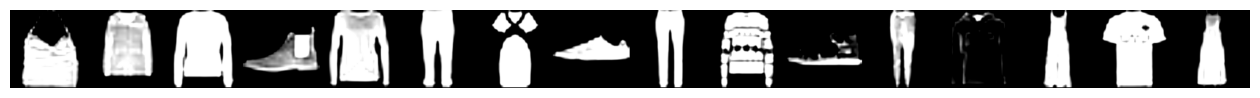

In [20]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

for images in test_loader:
    images = images[:16]
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [21]:
submission_df.head(10)

,id,label
0,60000,8
1,60001,4
2,60002,2
3,60003,9
4,60004,2
5,60005,1
6,60006,3
7,60007,7
8,60008,1
9,60009,2
